In [12]:
%matplotlib inline

In [13]:
import matplotlib.pylab as plt
import torch
import numpy as np
import seaborn as sn
sn.set_context("poster")
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import weight_norm
from torchvision import transforms, datasets

from deepsith import DeepSITH

import numpy as np
import scipy
import scipy.stats as st
import scipy.special
import scipy.signal
import scipy.interpolate

import pandas as pd

from os.path import join
import random
from csv import DictWriter

from tqdm.notebook import tqdm
import pickle
# if gpu is to be used
use_cuda = torch.cuda.is_available()
print(use_cuda)
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
DoubleTensor = torch.cuda.DoubleTensor if use_cuda else torch.DoubleTensor
IntTensor = torch.cuda.IntTensor if use_cuda else torch.IntTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
ttype = FloatTensor

True


In [14]:
import torch
import numpy as np

def get_batch(batch_size, T, ttype):
    values = torch.rand(T, batch_size, requires_grad=False)
    indices = torch.zeros_like(values)
    half = int(T / 2)
    for i in range(batch_size):
        half_1 = np.random.randint(half)
        hals_2 = np.random.randint(half, T)
        indices[half_1, i] = 1
        indices[hals_2, i] = 1

    data = torch.stack((values, indices), dim=-1).type(ttype)
    targets = torch.mul(values, indices).sum(dim=0).type(ttype)
    return data, targets


In [15]:
torch.manual_seed(1111)

In [16]:
seq_length = 600

In [17]:
xtemp, ytemp = get_batch(4, seq_length, ttype=ttype)
print(xtemp.shape, ytemp.shape)

torch.Size([600, 4, 2]) torch.Size([4])


In [18]:
xtemp.transpose(0,1).transpose(1,2).unsqueeze(1)

tensor([[[[0.4606, 0.9548, 0.5145,  ..., 0.5468, 0.3088, 0.1194],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0850, 0.5982, 0.8125,  ..., 0.1295, 0.0968, 0.9441],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.8009, 0.4821, 0.3122,  ..., 0.5019, 0.9653, 0.9626],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.3972, 0.9446, 0.9756,  ..., 0.9959, 0.1073, 0.8790],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]]],
       device='cuda:0')

In [19]:
X_train.shape

NameError: name 'X_train' is not defined

In [54]:
def train(model, ttype, seq_length, optimizer, loss_func, 
          epoch, perf_file, loss_buffer_size=20, batch_size=1, test_size=10,
          device='cuda', prog_bar=None):
    assert(loss_buffer_size%batch_size==0)

    losses = []
    perfs = []
    last_test_perf = 0
    for batch_idx in range(20000):
        model.train()
        sig, target = get_batch(batch_size, seq_length, ttype=ttype)
        sig = sig.transpose(0,1).transpose(1,2).unsqueeze(1)
        target = target.unsqueeze(1)
        optimizer.zero_grad()
        out = model(sig)
        loss = loss_func(out[:, -1, :],
                         target)
         
        loss.backward()
        optimizer.step()

        losses.append(loss.detach().cpu().numpy())
        losses = losses[-loss_buffer_size:]
        if not (prog_bar is None):
            # Update progress_bar
            s = "{}:{} Loss: {:.8f}"
            format_list = [e, int(batch_idx/(50/batch_size)), np.mean(losses)]         
            s = s.format(*format_list)
            prog_bar.set_description(s)
        if ((batch_idx*batch_size)%loss_buffer_size == 0) & (batch_idx != 0):
            loss_track = {}
            #last_test_perf = test_norm(model, 'cuda', test_sig, test_class,
            #                                    batch_size=test_size, 
            #                                    )
            loss_track['avg_loss'] = np.mean(losses)
            #loss_track['last_test'] = last_test_perf
            loss_track['epoch'] = epoch
            loss_track['batch_idx'] = batch_idx
            with open(perf_file, 'a+') as fp:
                csv_writer = DictWriter(fp, fieldnames=list(loss_track.keys()))
                if fp.tell() == 0:
                    csv_writer.writeheader()
                csv_writer.writerow(loss_track)
                fp.flush()
def test_norm(model, device, seq_length, loss_func, batch_size=100):
    model.eval()
    correct = 0
    count = 0
    with torch.no_grad():
        sig, target = get_batch(batch_size, seq_length, ttype=ttype)
        sig = sig.transpose(0,1).transpose(1,2).unsqueeze(1)
        target = target.unsqueeze(1)
        out = model(sig)
        loss = loss_func(out[:, -1, :],
                         target)
    return loss

In [21]:
class DeepSITH_Predictor(nn.Module):
    def __init__(self, out_features, layer_params, dropout=.5):
        super(DeepSITH_Predictor, self).__init__()
        last_hidden = layer_params[-1]['hidden_size']
        self.hs = DeepSITH(layer_params=layer_params, dropout=dropout)
        self.to_out = nn.Linear(last_hidden, out_features)
    def forward(self, inp):
        x = self.hs(inp)
        x = self.to_out(x)
        return x

In [37]:
import scipy.optimize as opt
from deepsith import iSITH
def min_fun(x, *args):
    ntau = int(args[2])
    k = int(x[0])
    if k < 4 or k>125:
        return np.inf
    tau_min = args[0]
    tau_max = args[1]    
    ev = iSITH(tau_min=tau_min, tau_max=tau_max, buff_max=tau_max*5, k=k, ntau=ntau, dt=1, g=1.0)    
    std_0 = ev.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1].sum(1)[int(tau_min):int(tau_max)].std()
    std_1 = ev.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1, ::2].sum(1)[int(tau_min):int(tau_max)].std()    
    to_min = std_0/std_1
    return to_min

   direc: array([[1.]])
     fun: 0.17088169
 message: 'Optimization terminated successfully.'
    nfev: 34
     nit: 2
  status: 0
 success: True
       x: array(7.28509207)
ntau: 8 k: 7


/home/bgj5hk/bin/anaconda3/lib/python3.6/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method Powell cannot handle constraints nor bounds.
  RuntimeWarning)
/home/bgj5hk/bin/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/bgj5hk/bin/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1986: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/home/bgj5hk/bin/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1987: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)


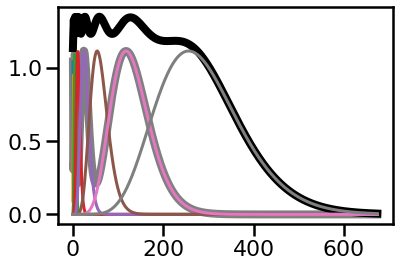

In [45]:
ntau_0 = 8
k_0 = 25
tau_min = 1.
tau_max = 225.
res = opt.minimize(min_fun, [k_0], args=(tau_min, tau_max, ntau_0), 
                   #method='Nelder-Mead',
                   method='Powell',
                   #method='L-BFGS-B',
                   #method='BFGS',
                   #method='CG',
                   #method='TNC',
                   bounds=[(4, 125)]
                  )
print(res)
ntau = ntau_0
k = int(res.x)
print('ntau:', ntau, 'k:', k)
ev = iSITH(tau_min=tau_min, tau_max=tau_max, buff_max=tau_max*3, k=k, ntau=ntau, dt=1.0, g=1.0)
plt.plot(ev.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1, ::2].sum(1),
        linewidth=8, color='grey');
plt.plot(ev.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1].sum(1),
        linewidth=8, color='black');
plt.plot(ev.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1],
       );

# T = 500

In [55]:
g = .0
sith_params1 = {"in_features":2, 
                "tau_min":1, "tau_max":25.0, 
                "k":21, 'dt':1,
                "ntau":8, 'g':g,  
                "ttype":ttype, 'batch_norm':False,
                "hidden_size":25, "act_func":nn.ReLU()}
sith_params2 = {"in_features":sith_params1['hidden_size'], 
                "tau_min":1, "tau_max":75.0, 
                "k":11, 'dt':1,
                "ntau":8, 'g':g, 
                "ttype":ttype, 'batch_norm':False,
                "hidden_size":25, "act_func":nn.ReLU()}
sith_params3 = {"in_features":sith_params2['hidden_size'], 
                "tau_min":1, "tau_max":225.0, 'buff_max':900, 
                "k":7, 'dt':1,
                "ntau":8, 'g':g, 
                "ttype":ttype, 'batch_norm':False,
                "hidden_size":25, "act_func":nn.ReLU()}


layer_params = [sith_params1, sith_params2, sith_params3]
model = DeepSITH_Predictor(out_features=1,
                           layer_params=layer_params, 
                           dropout=.0).cuda()

tot_weights = 0
for p in model.parameters():
    tot_weights += p.numel()
print("Total Weights:", tot_weights)
print(model)

Total Weights: 10501
DeepSITH_Predictor(
  (hs): DeepSITH(
    (layers): ModuleList(
      (0): _DeepSITH_core(
        (sith): iSITH(ntau=8, tau_min=1, tau_max=25.0, buff_max=75.0, dt=1, k=21, g=0.0)
        (linear): Linear(in_features=16, out_features=25, bias=True)
        (act_func): ReLU()
      )
      (1): _DeepSITH_core(
        (sith): iSITH(ntau=8, tau_min=1, tau_max=75.0, buff_max=225.0, dt=1, k=11, g=0.0)
        (linear): Linear(in_features=200, out_features=25, bias=True)
        (act_func): ReLU()
      )
      (2): _DeepSITH_core(
        (sith): iSITH(ntau=8, tau_min=1, tau_max=225.0, buff_max=900, dt=1, k=7, g=0.0)
        (linear): Linear(in_features=200, out_features=25, bias=True)
        (act_func): ReLU()
      )
    )
    (dropouts): ModuleList(
      (0): Dropout(p=0.0, inplace=False)
      (1): Dropout(p=0.0, inplace=False)
    )
  )
  (to_out): Linear(in_features=25, out_features=1, bias=True)
)


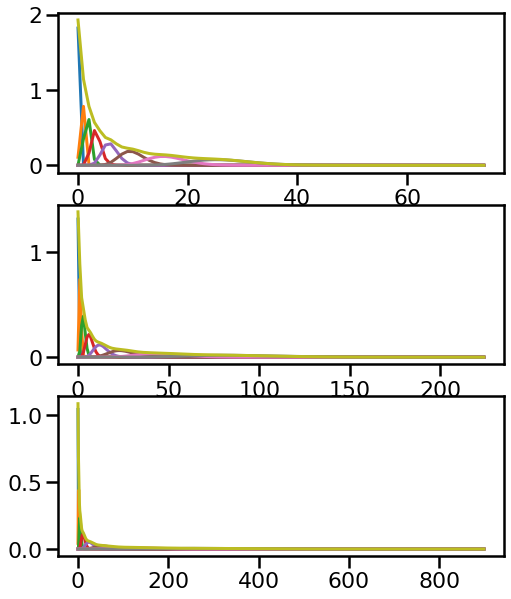

In [52]:
fig = plt.figure(figsize=(8,10))

ax = fig.add_subplot(3,1,1)
ax.plot(model.hs.layers[0].sith.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1],
       );
ax.plot(model.hs.layers[0].sith.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1].sum(1),
        );
ax = fig.add_subplot(3,1,2)
ax.plot(model.hs.layers[1].sith.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1],
        );
ax.plot(model.hs.layers[1].sith.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1].sum(1),
        );
ax = fig.add_subplot(3,1,3)
ax.plot(model.hs.layers[2].sith.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1],
        );
ax.plot(model.hs.layers[2].sith.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1].sum(1),
        );

In [56]:
seq_length=500

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 1
progress_bar = tqdm(range(int(epochs)), bar_format='{l_bar}{bar:5}{r_bar}{bar:-5b}')
for e in progress_bar:
    train(model, ttype, seq_length,
          optimizer, loss_func, batch_size=50, loss_buffer_size=100,
          epoch=e, perf_file=join('perf','adding500_deepsith_8.csv'),
          prog_bar=progress_bar)

# T = 2000

In [30]:
7*175

1225

In [57]:
g = .0
sith_params1 = {"in_features":2, 
                "tau_min":1, "tau_max":25.0, 'buff_max':45, 
                "k":35, 'dt':1,
                "ntau":10, 'g':g,  
                "ttype":ttype, 'batch_norm':False,
                "hidden_size":25, "act_func":nn.ReLU()}
sith_params2 = {"in_features":sith_params1['hidden_size'], 
                "tau_min":1, "tau_max":175.0, 'buff_max':500, 
                "k":13, 'dt':1,
                "ntau":10, 'g':g, 
                "ttype":ttype, 'batch_norm':False,
                "hidden_size":25, "act_func":nn.ReLU()}
sith_params3 = {"in_features":sith_params2['hidden_size'], 
                "tau_min":1, "tau_max":1225.0, 'buff_max':5000, 
                "k":6, 'dt':1,
                "ntau":10, 'g':g, 
                "ttype":ttype, 'batch_norm':False,
                "hidden_size":25, "act_func":nn.ReLU()}


layer_params = [sith_params1, sith_params2, sith_params3]
model = DeepSITH_Predictor(out_features=1,
                           layer_params=layer_params, 
                           dropout=.0).cuda()

tot_weights = 0
for p in model.parameters():
    tot_weights += p.numel()
print("Total Weights:", tot_weights)
print(model)

Total Weights: 13101
DeepSITH_Predictor(
  (hs): DeepSITH(
    (layers): ModuleList(
      (0): _DeepSITH_core(
        (sith): iSITH(ntau=10, tau_min=1, tau_max=25.0, buff_max=45, dt=1, k=35, g=0.0)
        (linear): Linear(in_features=20, out_features=25, bias=True)
        (act_func): ReLU()
      )
      (1): _DeepSITH_core(
        (sith): iSITH(ntau=10, tau_min=1, tau_max=175.0, buff_max=500, dt=1, k=13, g=0.0)
        (linear): Linear(in_features=250, out_features=25, bias=True)
        (act_func): ReLU()
      )
      (2): _DeepSITH_core(
        (sith): iSITH(ntau=10, tau_min=1, tau_max=1225.0, buff_max=5000, dt=1, k=6, g=0.0)
        (linear): Linear(in_features=250, out_features=25, bias=True)
        (act_func): ReLU()
      )
    )
    (dropouts): ModuleList(
      (0): Dropout(p=0.0, inplace=False)
      (1): Dropout(p=0.0, inplace=False)
    )
  )
  (to_out): Linear(in_features=25, out_features=1, bias=True)
)


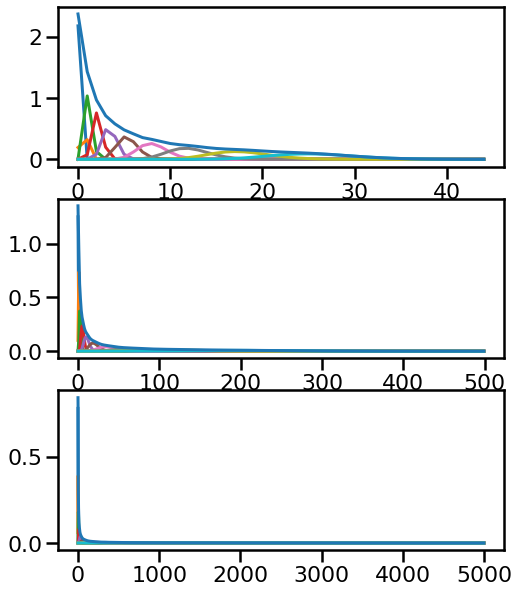

In [77]:
fig = plt.figure(figsize=(8,10))

ax = fig.add_subplot(3,1,1)
ax.plot(model.hs.layers[0].sith.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1],
       );
ax.plot(model.hs.layers[0].sith.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1].sum(1),
        );
ax = fig.add_subplot(3,1,2)
ax.plot(model.hs.layers[1].sith.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1],
        );
ax.plot(model.hs.layers[1].sith.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1].sum(1),
        );
ax = fig.add_subplot(3,1,3)
ax.plot(model.hs.layers[2].sith.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1],
        );
ax.plot(model.hs.layers[2].sith.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1].sum(1),
        );

In [58]:
seq_length=2000

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 1
progress_bar = tqdm(range(int(epochs)), bar_format='{l_bar}{bar:5}{r_bar}{bar:-5b}')
for e in progress_bar:
    train(model, ttype, seq_length,
          optimizer, loss_func, batch_size=50, loss_buffer_size=100,
          epoch=e, perf_file=join('perf','adding2000_deepsith_3.csv'),
          prog_bar=progress_bar)

#  T = 5000

In [112]:
20*6**np.arange(0,4,1)

array([  20,  120,  720, 4320])

In [61]:
g = 0.0
sith_params1 = {"in_features":2, 
                "tau_min":1, "tau_max":20.0, 'buff_max':30, 
                "k":74, 'dt':1,
                "ntau":13, 'g':g,  
                "ttype":ttype, 'batch_norm':False,
                "hidden_size":25, "act_func":nn.ReLU()}
sith_params2 = {"in_features":sith_params1['hidden_size'], 
                "tau_min":1, "tau_max":120.0, 'buff_max':250, 
                "k":27, 'dt':1,
                "ntau":13, 'g':g, 
                "ttype":ttype, 'batch_norm':False,
                "hidden_size":25, "act_func":nn.ReLU()}
sith_params3 = {"in_features":sith_params2['hidden_size'], 
                "tau_min":1, "tau_max":720.0, 'buff_max':2000, 
                "k":14, 'dt':1,
                "ntau":13, 'g':g, 
                "ttype":ttype, 'batch_norm':False,
                "hidden_size":25, "act_func":nn.ReLU()}
sith_params4 = {"in_features":sith_params3['hidden_size'], 
                "tau_min":1, "tau_max":4320.0, 'buff_max':12000, 
                "k":8, 'dt':1,
                "ntau":13, 'g':g, 
                "ttype":ttype, 'batch_norm':False,
                "hidden_size":25, "act_func":nn.ReLU()}

layer_params = [sith_params1, sith_params2, sith_params3, sith_params4]
model = DeepSITH_Predictor(out_features=1,
                           layer_params=layer_params, 
                           dropout=.0).cuda()

tot_weights = 0
for p in model.parameters():
    tot_weights += p.numel()
print("Total Weights:", tot_weights)
print(model)

Total Weights: 25151
DeepSITH_Predictor(
  (hs): DeepSITH(
    (layers): ModuleList(
      (0): _DeepSITH_core(
        (sith): iSITH(ntau=13, tau_min=1, tau_max=20.0, buff_max=30, dt=1, k=74, g=0.0)
        (linear): Linear(in_features=26, out_features=25, bias=True)
        (act_func): ReLU()
      )
      (1): _DeepSITH_core(
        (sith): iSITH(ntau=13, tau_min=1, tau_max=120.0, buff_max=250, dt=1, k=27, g=0.0)
        (linear): Linear(in_features=325, out_features=25, bias=True)
        (act_func): ReLU()
      )
      (2): _DeepSITH_core(
        (sith): iSITH(ntau=13, tau_min=1, tau_max=720.0, buff_max=2000, dt=1, k=14, g=0.0)
        (linear): Linear(in_features=325, out_features=25, bias=True)
        (act_func): ReLU()
      )
      (3): _DeepSITH_core(
        (sith): iSITH(ntau=13, tau_min=1, tau_max=4320.0, buff_max=12000, dt=1, k=8, g=0.0)
        (linear): Linear(in_features=325, out_features=25, bias=True)
        (act_func): ReLU()
      )
    )
    (dropouts): Modul

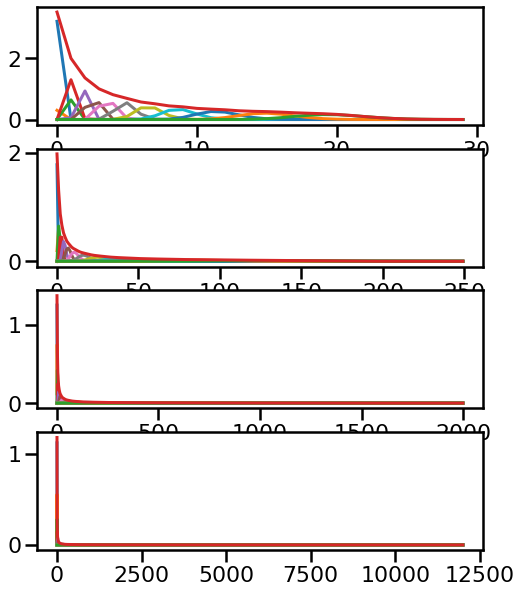

In [23]:
fig = plt.figure(figsize=(8,10))

ax = fig.add_subplot(4,1,1)
ax.plot(model.hs.layers[0].sith.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1],
       );
ax.plot(model.hs.layers[0].sith.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1].sum(1),
        );
ax = fig.add_subplot(4,1,2)
ax.plot(model.hs.layers[1].sith.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1],
        );
ax.plot(model.hs.layers[1].sith.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1].sum(1),
        );
ax = fig.add_subplot(4,1,3)
ax.plot(model.hs.layers[2].sith.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1],
        );
ax.plot(model.hs.layers[2].sith.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1].sum(1),
        );
ax = fig.add_subplot(4,1,4)
ax.plot(model.hs.layers[3].sith.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1],
        );
ax.plot(model.hs.layers[3].sith.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1].sum(1),
        );

In [ ]:
seq_length=5000

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 1
progress_bar = tqdm(range(int(epochs)), bar_format='{l_bar}{bar:5}{r_bar}{bar:-5b}')
for e in progress_bar:
    train(model, ttype, seq_length,
          optimizer, loss_func, batch_size=50, loss_buffer_size=100,
          epoch=e, perf_file=join('perf','adding5000_deepsith_3.csv'),
          prog_bar=progress_bar)

# Data Plot

In [10]:
dat = pd.read_csv(os.path.join('perf', 'adding500_deepsith_6.csv'))
dat2 = pd.read_csv(os.path.join('perf', 'adding2000_deepsith_2.csv'))
dat3 = pd.read_csv(os.path.join('perf', 'adding5000_deepsith_2.csv'))

FileNotFoundError: [Errno 2] File perf/adding5000_deepsith_2.csv does not exist: 'perf/adding5000_deepsith_2.csv'

In [8]:
dat['training_step'] = (dat.batch_idx)/100
dat2['training_step'] = (dat2.batch_idx)/100
dat3['training_step'] = (dat3.batch_idx)*10/5/100


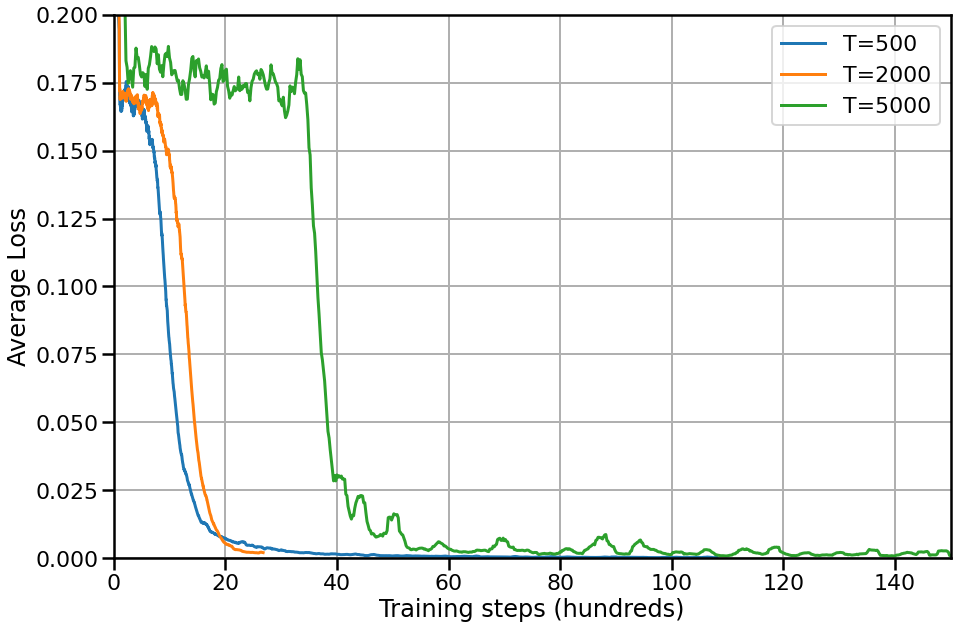

In [9]:

fig = plt.figure(figsize=(15,10))
sn.lineplot(data=dat, x=dat.training_step, y=dat.avg_loss,)
sn.lineplot(data=dat2, x=dat2.training_step, y=dat2.avg_loss,)
ax = sn.lineplot(data=dat3, x=dat3.training_step, y=dat3.avg_loss,)
plt.legend(['T=500', 'T=2000', 'T=5000'])
ax.set_xlabel('Training steps (hundreds)')
ax.set_ylabel('Average Loss')
ax.set_xlim(0, 150)
ax.set_ylim(0, .2)
plt.grid(True)
